# Laminar model comparison using free energy

This tutorial demonstrates how to perform laminar inference using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2018, Non-invasive laminar inference with MEG: Comparison of methods and source inversion algorithms](https://doi.org/10.1016/j.neuroimage.2017.11.068). A 20Hz oscillation is simulated at a particular cortical location in various layers. Source reconstruction is performed using the Empirical Bayesian Beamformer on the simulated sensor data using forward models based on different layer meshes. These models are then compared using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison
from lameg.util import get_surface_names, load_meg_sensor_data, get_fiducial_coords
from lameg.viz import show_surface
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas, lpa, rpa = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri', 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_data', subj_id, 'surf'), 
    'link_vector.fixed'
)

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/model_comp_fe'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
22-Jul-2024 05:29:35 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 05:29:35 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           05:29:36 - 22/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiome

## Simulating a signal on the pial surface
We're going to simulate 1s of a 20Hz sine wave with a dipole moment of 10nAm

Text(0, 0.5, 'Amplitude (nAm)')

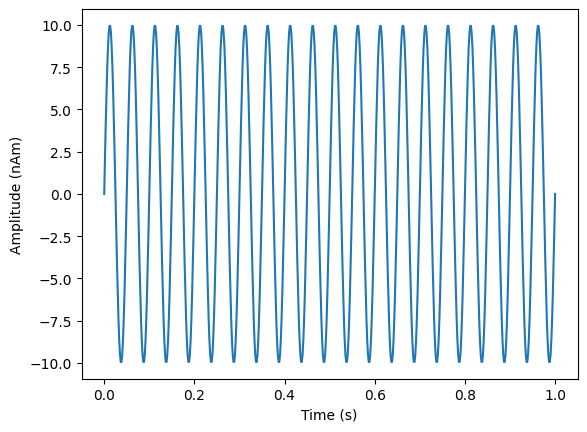

In [5]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 600

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,1,s_rate+1)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

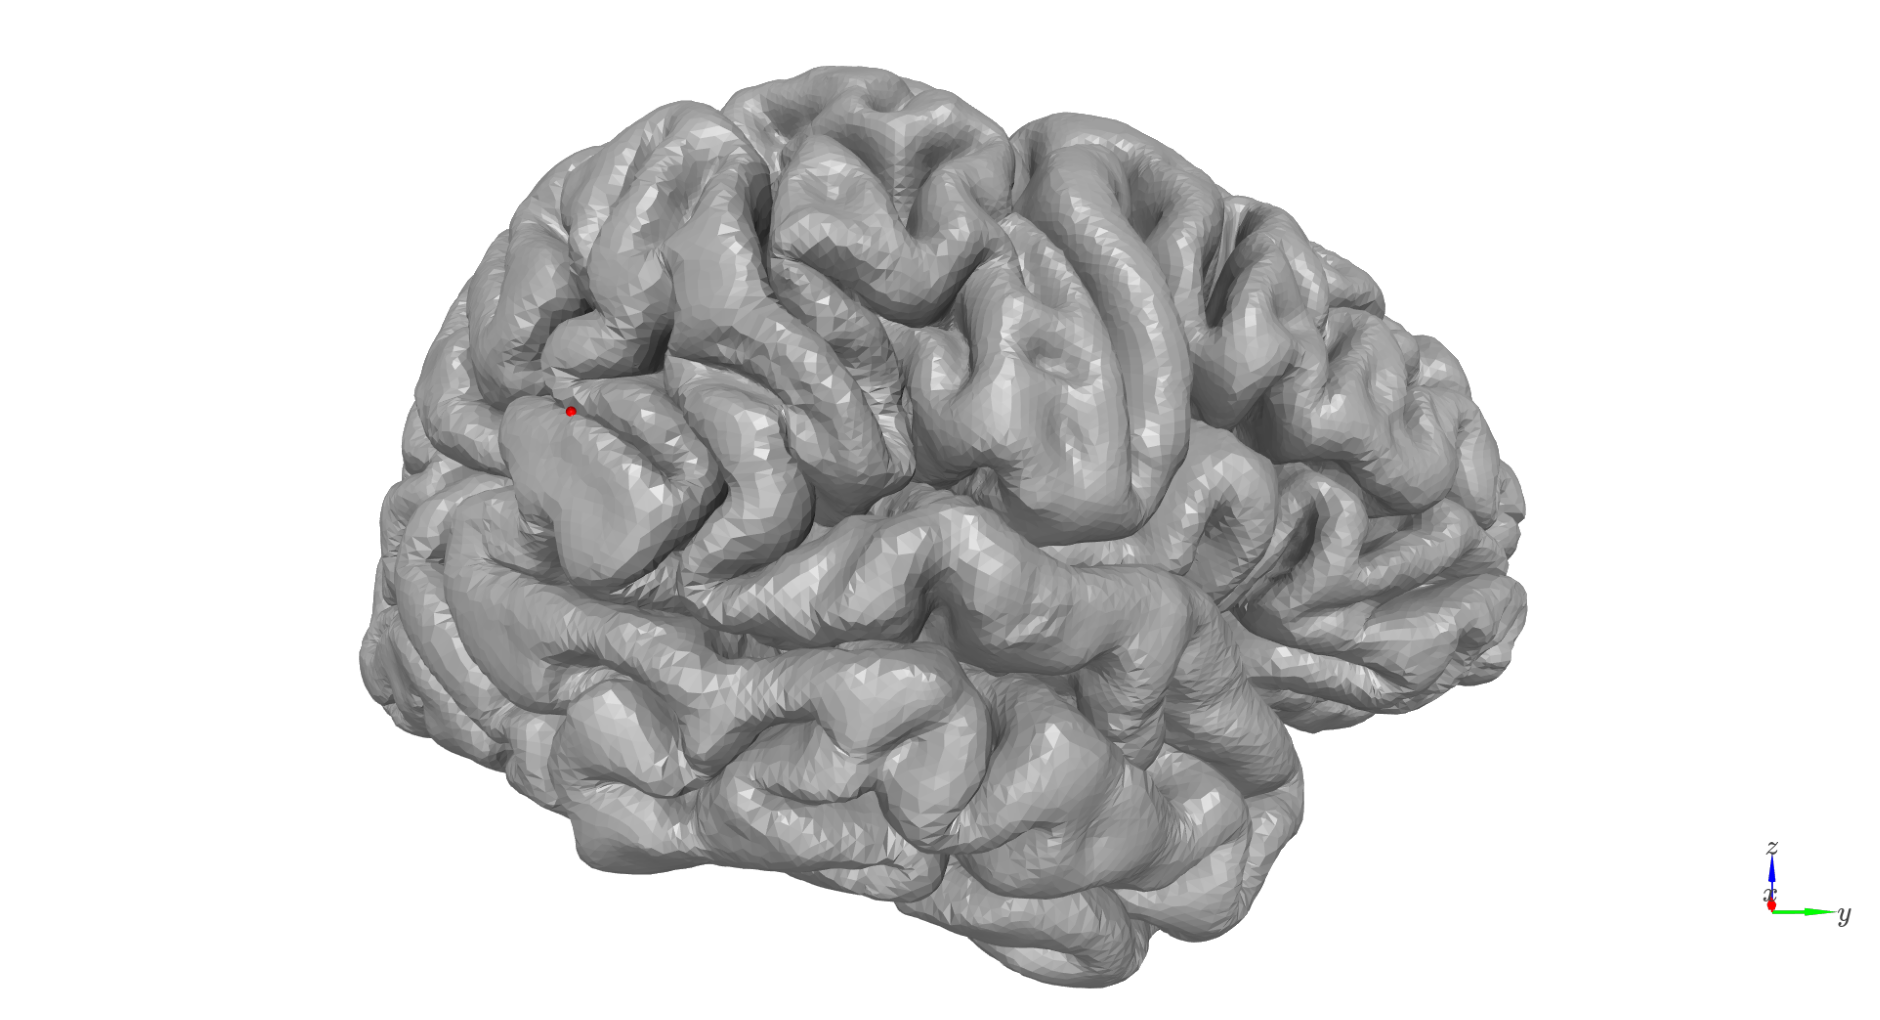

In [8]:
# Vertex to simulate activity at
sim_vertex=24585

pial_ds_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 655.24 pAm/mm2, peak momemnt density 1216.78 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 655.24, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1216.78, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior777361.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish

(-225.0, 225.0)

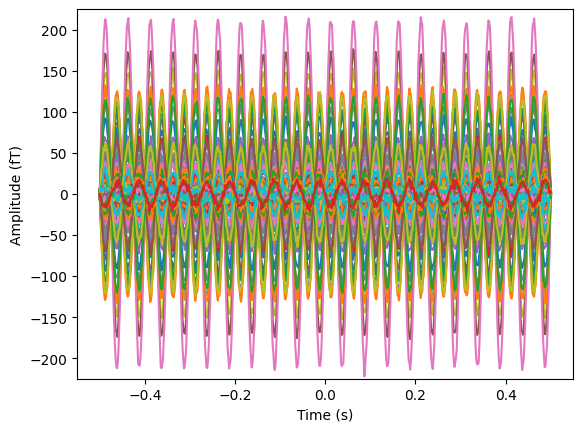

In [7]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -5

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)   

# Load simulated sensor data and plot
pial_sim_sensor_data, time, ch_names = load_meg_sensor_data(pial_sim_fname)
_ = plt.plot(time, np.mean(pial_sim_sensor_data,axis=-1).T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.ylim([-225, 225])

## Model comparison (pial - white matter)
Now we can run model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter). This should be positive (more model evidence for the pial surface model) because we simulated activity on the pial surface

In [8]:
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_] = model_comparison(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    pial_sim_fname, 
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes    
    }
)

# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be positive (more model evidence for the pial layer model)
F[0]-F[1]

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 05:45:06 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 05:45:06 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           05:45:21 - 22/07/2024
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 sy

white.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 system

SPM: spm_eeg_inv_forward                           05:46:59 - 22/07/2024
Completed                               :          05:47:00 - 22/07/2024
computing surface normals
22-Jul-2024 05:47:01 - Done    'Head model specification'
22-Jul-2024 05:47:01 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      05:47:02 - 22/07/2024
        ----------------------------------------------------------------
computing surf

18110.11524643004

## White matter surface simulation with pial - white matter model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, model comparison should yield greater model evidence for the white matter surface, and therefore the difference in free energy (pial - white matter) should be negative.

In [9]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_] = model_comparison(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    white_sim_fname, 
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes,    
    }
)
    
# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be negative (more model evidence for the white matter layer model)
F[0]-F[1]

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 522.28 pAm/mm2, peak momemnt density 1293.99 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 522.28, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1293.99, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior182056.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Fini



------------------------------------------------------------------------
22-Jul-2024 05:54:25 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 05:54:25 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           05:54:27 - 22/07/2024
white.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 system

SPM: spm_eeg_inv_forward                           05:54:55 - 22/07/2024
Completed                               :          05:54:56 - 22/07/2024
computing surface normals
22-Jul-2024 05:54:57 - Done    'Head model specification'
22-Jul-2024 05:54:57 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_whi

-10886.761654135888

Here's the sensor signals from the simulation of activity on the white matter surface. It's very similar to the sensor signals from the pial surface simulation

(-225.0, 225.0)

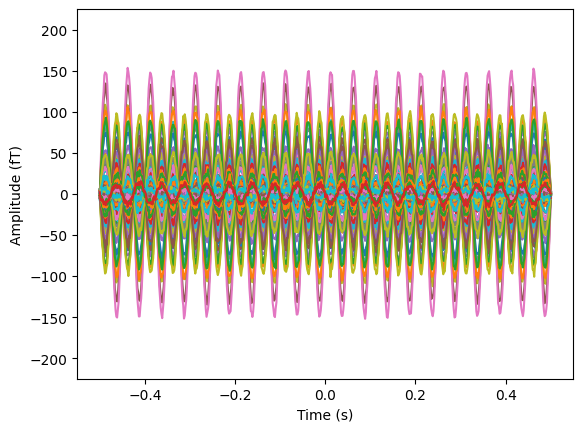

In [10]:
# Load simulated sensor data and plot
white_sim_sensor_data, time, ch_names = load_meg_sensor_data(white_sim_fname)
_ = plt.plot(time, np.mean(white_sim_sensor_data,axis=-1).T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.ylim([-225, 225])

The difference between the two simulated sensor signals is quite small

(-225.0, 225.0)

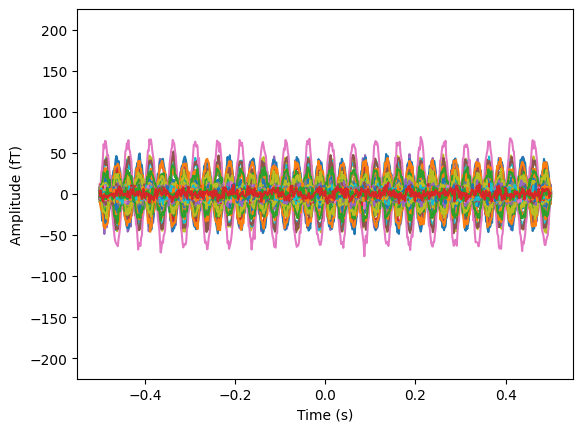

In [11]:
sensor_diff = pial_sim_sensor_data - white_sim_sensor_data
_ = plt.plot(time, np.mean(sensor_diff,axis=-1).T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.ylim([-225, 225])

## Simulation in each layer with model comparison across layers
That was model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run model comparison across all layers. We'll turn off SPM visualization here.

In [12]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
all_layerF = []

for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = l*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}_{l}_'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    ) 

    [layerF,_] = model_comparison(
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        layer_fnames, 
        l_sim_fname, 
        viz=False,
        spm_instance=spm,
        invert_kwargs={
            'patch_size': patch_size, 
            'n_temp_modes': n_temp_modes        
        }
    )
    all_layerF.append(layerF)
all_layerF = np.array(all_layerF)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 655.24 pAm/mm2, peak momemnt density 1216.78 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 655.24, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1216.78, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior182056.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end a

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 06:03:17 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:03:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumbe

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           06:05:17 - 22/07/2024
Completed                               :          06:05:17 - 22/07/2024
22-Jul-2024 06:05:18 - Done    'Head model specification'
22-Jul-2024 06:05:18 - Done

Smoothing ../test_data/sub-104/surf/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:05:19 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_0_spm-converted_autoreject-sub-104-ses-0

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.140414e+04 [+4.12]
  ReML Iteration 2                      :        ...2.979564e+04 [+4.25]
  ReML Iteration 3                      :        ...2.707969e+04 [+4.38]
  ReML Iteration 4                      :        ...2.216541e+04 [+4.50]
  ReML Iteration 5                      :        ...4.646180e+02 [+4.62]
  ReML Iteration 6                      :        ...8.832734e-01 [+4.75]
  ReML Iteration 7                      :        ...1.673268e-02 [+4.88]
  ReML Iteration 8                      :        ...3.545792e-04 [+5.00]
Percent variance explained 99.98 (57.79)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 06:07:14 - Done    'Source inversion, iterative'
22-Jul-2024 06:07:14 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.80 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.107643e+04 [+4.12]
  ReML Iteration 2                      :        ...2.933741e+04 [+4.25]
  ReML Iteration 3                      :        ...2.657386e+04 [+4.

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:11:24 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


----



------------------------------------------------------------------------
22-Jul-2024 06:13:21 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:13:21 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           06:13:46 - 22/07/2024
Completed                               :          06:13:46 - 22/07/2024
22-Jul-2024 06:13:47 - Done    'Head model specification'
22-Jul-2024 06:13:47 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:13:48 - 22/07/2024
        -----------------------------------------


gainname =

    'SPMgainmatrix_sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.201480e+04 [+4.12]
  ReML Iteration 2                      :        ...3.078577e+04 [+4.25]
  ReML Iteration 3                      :        ...2.824037e+04 [+4.38]
  ReML Iteration 4                      :        ...2.329804e+04 [+4.50]
  

Completed                               :          06:22:42 - 22/07/2024
22-Jul-2024 06:22:43 - Done    'Head model specification'
22-Jul-2024 06:22:43 - Done

Smoothing ../test_data/sub-104/surf/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:22:43 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a

Percent variance explained 99.99 (57.61)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 06:24:47 - Done    'Source inversion, iterative'
22-Jul-2024 06:24:47 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 06:24:49 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:24:49 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           06:25:13 - 2

Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.125773e+04 [+4.12]
  ReML Iteration 2                      :        ...2.959782e+04 [+4.25]
  ReML Iteration 3                      :        ...2.686329e+04 [+4.38]
  ReML Iteration 4                      :        ...2.192037e+04 [+4.50]
  ReML Iteration 5                      :        ...3.959757e+02 [+4.62]
  ReML Iteration 6                      :        ...8.362550e-01 [+4.75]
  ReML Iteration 7                      :        ...1.110944e-02 [+4.88]
  ReML Iteration 8                      :        ...1.672874e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.125773e+04 [+4.12]
  ReML Iteration 2                      :        ...2.959782e+04 [+4.25]
  ReML 



------------------------------------------------------------------------
22-Jul-2024 06:29:14 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:29:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.62 percent average variance
NB smooth EBB algorithm !
Using 1


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:31:19 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home

Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 529.41 pAm/mm2, peak momemnt density 1007.87 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 529.41, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1007.87, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_da

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 06:40:39 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:40:39 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumbe



------------------------------------------------------------------------
22-Jul-2024 06:42:13 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:42:13 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           06:42:38 - 22/07/2024
Completed                               :          06:42:38 - 22/07/2024
22-Jul-2024 06:42:39 - Done    'Head model specification'
22-Jul-2024 06:42:39 - Done

Smoothing ../test_data/sub-104/surf/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:42:40 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.178136e+04 [+4.12]
  ReML Iteration 2                      :        ...3.037364e+04 [+4.25]
  ReML Iteration 3                      :        ...2.771837e+04 [+4.38]
  ReML Iteration 4                      :        ...2.275789e+04 [+4.50]
  ReML Iteration 5                      :        ...6.240353e+02 [+4.62]
  ReML Iteration 6                      :        ...2.332754e+00 [+4.75]
  ReML Iteration 7                      :        ...7.491047e-02 [+4.88]
  ReML Iteration 8                      :        ...2.818117e-03 [+5.00]
Percent variance explained 99.99 (57.40)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 06:44:35 - Done    'Source inversion, iterative'
22-Jul-2024 06:44:35 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.143721e+04 [+4.12]
  ReML Iteration 2                      :        ...2.983907e+04 [+4.25]
  ReML Iteration 3                      :        ...2.710810e+04 [+4.

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:48:38 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


----



------------------------------------------------------------------------
22-Jul-2024 06:50:34 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 06:50:35 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           06:50:59 - 22/07/2024
Completed                               :          06:50:59 - 22/07/2024
22-Jul-2024 06:51:00 - Done    'Head model specification'
22-Jul-2024 06:51:00 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:51:01 - 22/07/2024
        -----------------------------------------


gainname =

    'SPMgainmatrix_sim_24585_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.18 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.173823e+04 [+4.12]
  ReML Iteration 2                      :        ...3.030846e+04 [+4.25]
  ReML Iteration 3                      :        ...2.765247e+04 [+4.38]
  ReML Iteration 4                      :        ...2.268911e+04 [+4.50]
  

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      06:59:59 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


----

Percent variance explained 99.99 (57.17)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 07:01:53 - Done    'Source inversion, iterative'
22-Jul-2024 07:01:53 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 07:01:55 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:01:55 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:02:19 - 2

Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.18 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.178634e+04 [+4.12]
  ReML Iteration 2                      :        ...3.037596e+04 [+4.25]
  ReML Iteration 3                      :        ...2.770515e+04 [+4.38]
  ReML Iteration 4                      :        ...2.272099e+04 [+4.50]
  ReML Iteration 5                      :        ...5.844995e+02 [+4.62]
  ReML Iteration 6                      :        ...2.336385e+00 [+4.75]
  ReML Iteration 7                      :        ...6.513481e-02 [+4.88]
  ReML Iteration 8                      :        ...2.149118e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.178634e+04 [+4.12]
  ReML Iteration 2                      :        ...3.037596e+04 [+4.25]
  ReML 


Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 07:06:18 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:06:18 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testch



------------------------------------------------------------------------
22-Jul-2024 07:07:59 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:07:59 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:08:24 - 22/07/2024
Completed                               :          07:08:24 - 22/07/2024
22-Jul-2024 07:08:25 - Done    'Head model specification'
22-Jul-2024 07:08:25 - Done

Smoothing ../test_data/sub-104/surf/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:08:26 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.096767e+04 [+4.12]
  ReML Iteration 2                      :        ...2.917145e+04 [+4.25]
  ReML Iteration 3                      :        ...2.634681e+04 [+4.38]
  ReML Iteration 4                      :        ...2.137128e+04 [+4.50]
  ReML Iteration 5                      :        ...1.776384e+02 [+4.62]
  ReML Iteration 6                      :        ...1.897970e-01 [+4.75]
  ReML Iteration 7                      :        ...8.270219e-04 [+4.88]
Percent variance explained 99.98 (57.16)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 07:10:21 - Done    'Source inversion, iterative'
22-Jul-2024 07:10:21 - Done

Simulating in layer 4
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 


Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:23:51 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


----

Percent variance explained 99.99 (56.99)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 07:25:46 - Done    'Source inversion, iterative'
22-Jul-2024 07:25:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 07:25:48 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:25:48 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:26:12 - 2

Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.211838e+04 [+4.12]
  ReML Iteration 2                      :        ...3.100222e+04 [+4.25]
  ReML Iteration 3                      :        ...2.856945e+04 [+4.38]
  ReML Iteration 4                      :        ...2.361936e+04 [+4.50]
  ReML Iteration 5                      :        ...6.539818e+02 [+4.62]
  ReML Iteration 6                      :        ...6.715532e+00 [+4.75]
  ReML Iteration 7                      :        ...3.280261e-01 [+4.88]
  ReML Iteration 8                      :        ...2.127500e-02 [+5.00]
  ReML Iteration 9                      :        ...1.300626e-03 [+5.12]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.211838e+04 [+4.12]
  ReML 


Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 07:30:11 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:30:11 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testch



------------------------------------------------------------------------
22-Jul-2024 07:31:46 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:31:46 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:32:11 - 22/07/2024
Completed                               :          07:32:11 - 22/07/2024
22-Jul-2024 07:32:12 - Done    'Head model specification'
22-Jul-2024 07:32:12 - Done

Smoothing ../test_data/sub-104/surf/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:32:13 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.129737e+04 [+4.12]
  ReML Iteration 2                      :        ...2.963428e+04 [+4.25]
  ReML Iteration 3                      :        ...2.686124e+04 [+4.38]
  ReML Iteration 4                      :        ...2.186277e+04 [+4.50]
  ReML Iteration 5                      :        ...3.232732e+02 [+4.62]
  ReML Iteration 6                      :        ...6.296899e-01 [+4.75]
  ReML Iteration 7                      :        ...6.506542e-03 [+4.88]
Percent variance explained 99.98 (56.98)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 07:34:08 - Done    'Source inversion, iterative'
22-Jul-2024 07:34:08 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mappi


Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 07:41:31 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:41:31 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testch



------------------------------------------------------------------------
22-Jul-2024 07:43:06 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:43:06 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:43:31 - 22/07/2024
Completed                               :          07:43:31 - 22/07/2024
22-Jul-2024 07:43:32 - Done    'Head model specification'
22-Jul-2024 07:43:32 - Done

Smoothing ../test_data/sub-104/surf/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:43:33 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.180349e+04 [+4.12]
  ReML Iteration 2                      :        ...3.040524e+04 [+4.25]
  ReML Iteration 3                      :        ...2.772800e+04 [+4.38]
  ReML Iteration 4                      :        ...2.267859e+04 [+4.50]
  ReML Iteration 5                      :        ...6.942171e+02 [+4.62]
  ReML Iteration 6                      :        ...3.596821e+00 [+4.75]
  ReML Iteration 7                      :        ...1.251247e-01 [+4.88]
  ReML Iteration 8                      :        ...5.269364e-03 [+5.00]
Percent variance explained 99.99 (56.80)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 07:45:29 - Done    'Source inversion, iterative'
22-Jul-2024 07:45:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    



------------------------------------------------------------------------
22-Jul-2024 07:47:46 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 07:47:46 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.81 percent average variance
NB smooth EBB algorithm !
Using 1

0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           07:50:11 - 22/07/2024
Completed                               :          07:50:12 - 22/07/2024
22-Jul-2024 07:50:13 - Done    'Head model specification'
22-Jul-2024 07:50:13 - Done

Smoothing ../test_data/sub-104/surf/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      07:50:13 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_5_spm-converted_autoreject-sub-104-ses-0

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.144254e+04 [+4.12]
  ReML Iteration 2                      :        ...2.984665e+04 [+4.25]
  ReML Iteration 3                      :        ...2.709112e+04 [+4.38]
  ReML Iteration 4                      :        ...2.204314e+04 [+4.50]
  ReML Iteration 5                      :        ...4.540839e+02 [+4.62]
  ReML Iteration 6                      :        ...1.229874e+00 [+4.75]
  ReML Iteration 7                      :        ...2.115342e-02 [+4.88]
  ReML Iteration 8                      :        ...4.189490e-04 [+5.00]
Percent variance explained 99.98 (56.80)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 07:52:28 - Done    'Source inversion, iterative'
22-Jul-2024 07:52:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.81 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.103878e+04 [+4.12]
  ReML Iteration 2                      :        ...2.929823e+04 [+4.25]
  ReML Iteration 3                      :        ...2.649802e+04 [+4.

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 08:02:43 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:02:43 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:03:13 - 22/07/2024
Completed                               :          08:03:13 - 22/07/2024
22-Jul-2024 08:03:14 - Done    'Head model specification'
22-Jul-2024 08:03:14 - Done

Smoothing ../t

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.161748e+04 [+4.12]
  ReML Iteration 2                      :        ...3.011657e+04 [+4.25]
  ReML Iteration 3                      :        ...2.740347e+04 [+4.38]
  ReML Iteration 4                      :        ...2.233439e+04 [+4.50]
  ReML Iteration 5                      :        ...6.631730e+02 [+4.62]
  ReML Iteration 6                      :        ...3.003103e+00 [+4.75]
  ReML Iteration 7                      :        ...8.789787e-02 [+4.88]
  ReML Iteration 8                      :        ...3.079289e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.161748e+04 [+4.12]
  ReML Iteration 2                      :        ...3.011657e+04 [+4.25]
  ReML Iteration 3                      :        ...2.740347e+04 [+4.38]
  ReML Iteration 4                      :        ...2.233439e+04 [+4.50]
  ReML Iteration 5               



------------------------------------------------------------------------
22-Jul-2024 08:07:39 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:07:39 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_6_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.58 percent average variance
NB smooth EBB algorithm !
Using 1

0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:09:44 - 22/07/2024
Completed                               :          08:09:45 - 22/07/2024
22-Jul-2024 08:09:46 - Done    'Head model specification'
22-Jul-2024 08:09:46 - Done

Smoothing ../test_data/sub-104/surf/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:09:46 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_6_spm-converted_autoreject-sub-104-ses-0

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.193202e+04 [+4.12]
  ReML Iteration 2                      :        ...3.062126e+04 [+4.25]
  ReML Iteration 3                      :        ...2.797191e+04 [+4.38]
  ReML Iteration 4                      :        ...2.288505e+04 [+4.50]
  ReML Iteration 5                      :        ...6.338432e+02 [+4.62]
  ReML Iteration 6                      :        ...3.927860e+00 [+4.75]
  ReML Iteration 7                      :        ...1.333969e-01 [+4.88]
  ReML Iteration 8                      :        ...5.618152e-03 [+5.00]
Percent variance explained 99.99 (56.57)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 08:11:44 - Done    'Source inversion, iterative'
22-Jul-2024 08:11:44 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_6_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.58 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.146553e+04 [+4.12]
  ReML Iteration 2                      :        ...2.987401e+04 [+4.25]
  ReML Iteration 3                      :        ...2.710438e+04 [+4.

end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 08:20:36 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:20:36 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:21:20 - 22/07/2024
Completed                               :          08:21:21 - 22/07/2024
22-Jul-2024 08:21:22 - Done    'Head model specification'
22-Jul-2024 08:21:22 -

Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.142657e+04 [+4.12]
  ReML Iteration 2                      :        ...2.984178e+04 [+4.25]
  ReML Iteration 3                      :        ...2.711210e+04 [+4.38]
  ReML Iteration 4                      :        ...2.205873e+04 [+4.50]
  ReML Iteration 5                      :        ...6.015748e+02 [+4.62]
  ReML Iteration 6                      :        ...2.116848e+00 [+4.75]
  ReML Iteration 7                      :        ...5.088959e-02 [+4.88]
  ReML Iteration 8                      :        ...1.432966e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.142657e+04 [+4.12]
  ReML Iteration 2                      :        ...2.984178e+04 [+4.25]
  ReML Iteration 3                      :        ...

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 08:25:59 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:25:59 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_7_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce



------------------------------------------------------------------------
22-Jul-2024 08:27:50 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:27:50 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:28:26 - 22/07/2024
Completed                               :          08:28:26 - 22/07/2024
22-Jul-2024 08:28:27 - Done    'Head model specification'
22-Jul-2024 08:28:27 - Done

Smoothing ../test_data/sub-104/surf/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:28:28 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.195140e+04 [+4.12]
  ReML Iteration 2                      :        ...3.065821e+04 [+4.25]
  ReML Iteration 3                      :        ...2.802600e+04 [+4.38]
  ReML Iteration 4                      :        ...2.295120e+04 [+4.50]
  ReML Iteration 5                      :        ...6.668504e+02 [+4.62]
  ReML Iteration 6                      :        ...4.503793e+00 [+4.75]
  ReML Iteration 7                      :        ...1.663519e-01 [+4.88]
  ReML Iteration 8                      :        ...7.687685e-03 [+5.00]
Percent variance explained 99.99 (56.41)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 08:30:43 - Done    'Source inversion, iterative'
22-Jul-2024 08:30:43 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    



------------------------------------------------------------------------
22-Jul-2024 08:33:06 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:33:06 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_7_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.41 percent average variance
NB smooth EBB algorithm !
Using 1

Completed                               :          08:35:29 - 22/07/2024
22-Jul-2024 08:35:30 - Done    'Head model specification'
22-Jul-2024 08:35:30 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:35:31 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_7_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a

Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.124660e+04 [+4.12]
  ReML Iteration 2                      :        ...2.960840e+04 [+4.25]
  ReML Iteration 3                      :        ...2.686137e+04 [+4.38]
  ReML Iteration 4                      :        ...2.176577e+04 [+4.50]
  ReML Iteration 5                      :        ...5.884298e+02 [+4.62]
  ReML Iteration 6                      :        ...1.917615e+00 [+4.75]
  ReML Iteration 7                      :        ...4.100673e-02 [+4.88]
  ReML Iteration 8                      :        ...1.022094e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.124660e+04 [+4.12]
  ReML Iteration 2                      :        ...2.960840e+04 [+4.25]
  ReML 


Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 08:46:02 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:46:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testch



------------------------------------------------------------------------
22-Jul-2024 08:48:04 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 08:48:04 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:48:34 - 22/07/2024
Completed                               :          08:48:34 - 22/07/2024
22-Jul-2024 08:48:35 - Done    'Head model specification'
22-Jul-2024 08:48:35 - Done

Smoothing ../test_data/sub-104/surf/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:48:36 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.164583e+04 [+4.12]
  ReML Iteration 2                      :        ...3.015189e+04 [+4.25]
  ReML Iteration 3                      :        ...2.742022e+04 [+4.38]
  ReML Iteration 4                      :        ...2.231147e+04 [+4.50]
  ReML Iteration 5                      :        ...6.214188e+02 [+4.62]
  ReML Iteration 6                      :        ...3.002037e+00 [+4.75]
  ReML Iteration 7                      :        ...7.845909e-02 [+4.88]
  ReML Iteration 8                      :        ...2.481302e-03 [+5.00]
Percent variance explained 99.99 (56.21)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 08:50:51 - Done    'Source inversion, iterative'
22-Jul-2024 08:50:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.195423e+04 [+4.12]
  ReML Iteration 2                      :        ...3.065775e+04 [+4.25]
  ReML Iteration 3                      :        ...2.800411e+04 [+4.

Completed                               :          08:55:13 - 22/07/2024
22-Jul-2024 08:55:14 - Done    'Head model specification'
22-Jul-2024 08:55:14 - Done

Smoothing ../test_data/sub-104/surf/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:55:15 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a

Percent variance explained 99.98 (56.21)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 08:57:12 - Done    'Source inversion, iterative'
22-Jul-2024 08:57:12 - Done

Simulating in layer 9
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_fe/simprior_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 535.97 pAm/mm2, peak momemnt density 1247.07 pAm/mm2 
Prior 1. Average Mean

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 09:04:57 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:04:57 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce



------------------------------------------------------------------------
22-Jul-2024 09:06:55 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:06:55 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           09:07:29 - 22/07/2024
Completed                               :          09:07:30 - 22/07/2024
22-Jul-2024 09:07:31 - Done    'Head model specification'
22-Jul-2024 09:07:31 - Done

Smoothing ../test_data/sub-104/surf/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      09:07:32 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.158396e+04 [+4.12]
  ReML Iteration 2                      :        ...3.005488e+04 [+4.25]
  ReML Iteration 3                      :        ...2.730029e+04 [+4.38]
  ReML Iteration 4                      :        ...2.216082e+04 [+4.50]
  ReML Iteration 5                      :        ...6.011460e+02 [+4.62]
  ReML Iteration 6                      :        ...2.873408e+00 [+4.75]
  ReML Iteration 7                      :        ...6.959216e-02 [+4.88]
  ReML Iteration 8                      :        ...2.040761e-03 [+5.00]
Percent variance explained 99.99 (56.04)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 09:10:08 - Done    'Source inversion, iterative'
22-Jul-2024 09:10:08 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                    

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.05 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.175242e+04 [+4.12]
  ReML Iteration 2                      :        ...3.031139e+04 [+4.25]
  ReML Iteration 3                      :        ...2.757862e+04 [+4.

22-Jul-2024 09:15:24 - Done    'Head model specification'
22-Jul-2024 09:15:24 - Done

Smoothing ../test_data/sub-104/surf/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      09:15:25 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            

Percent variance explained 99.99 (56.04)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 09:17:39 - Done    'Source inversion, iterative'
22-Jul-2024 09:17:39 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 09:17:40 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:17:40 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           09:18:13 - 2



------------------------------------------------------------------------
22-Jul-2024 09:26:02 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:26:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1

Completed                               :          09:28:18 - 22/07/2024
22-Jul-2024 09:28:19 - Done    'Head model specification'
22-Jul-2024 09:28:19 - Done

Smoothing ../test_data/sub-104/surf/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      09:28:20 - 22/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019

Percent variance explained 99.99 (55.89)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 09:30:35 - Done    'Source inversion, iterative'
22-Jul-2024 09:30:35 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 09:30:37 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:30:37 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           09:31:05 - 2

Using 274 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...3.140676e+04 [+4.12]
  ReML Iteration 2                      :        ...2.980771e+04 [+4.25]
  ReML Iteration 3                      :        ...2.704093e+04 [+4.38]
  ReML Iteration 4                      :        ...2.190163e+04 [+4.50]
  ReML Iteration 5                      :        ...5.330947e+02 [+4.62]
  ReML Iteration 6                      :        ...2.051491e+00 [+4.75]
  ReML Iteration 7                      :        ...4.007317e-02 [+4.88]
  ReML Iteration 8                      :        ...9.300092e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.140676e+04 [+4.12]
  ReML Iteration 2                      :        ...2.980771e+04 [+4.25]
  ReML 


Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_fe/sim_24585_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 09:35:44 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:35:44 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testc



------------------------------------------------------------------------
22-Jul-2024 09:37:31 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:37:31 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           09:37:56 - 22/07/2024
Completed                               :          09:37:56 - 22/07/2024
22-Jul-2024 09:37:57 - Done    'Head model specification'
22-Jul-2024 09:37:57 - Done

Smoothing ../test_data/sub-104/surf/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      09:37:58 - 22/07/2024
        -----------------------------------------

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.210850e+04 [+4.12]
  ReML Iteration 2                      :        ...3.097835e+04 [+4.25]
  ReML Iteration 3                      :        ...2.849318e+04 [+4.38]
  ReML Iteration 4                      :        ...2.338507e+04 [+4.50]
  ReML Iteration 5                      :        ...5.945458e+02 [+4.62]
  ReML Iteration 6                      :        ...7.091512e+00 [+4.75]
  ReML Iteration 7                      :        ...3.198950e-01 [+4.88]
  ReML Iteration 8                      :        ...1.979607e-02 [+5.00]
  ReML Iteration 9                      :        ...1.150324e-03 [+5.12]
Percent variance explained 99.99 (55.89)
model evidences relative to maximum:

ans =

     0

22-Jul-2024 09:39:54 - Done    'Source inversion, iterative'
22-Jul-2024 09:39:54 - Done



For each simulation, we can plot the free energy for all models relative to the worst model. The layer model with the highest free energy should correspond to the layer that the activity was simulated in.

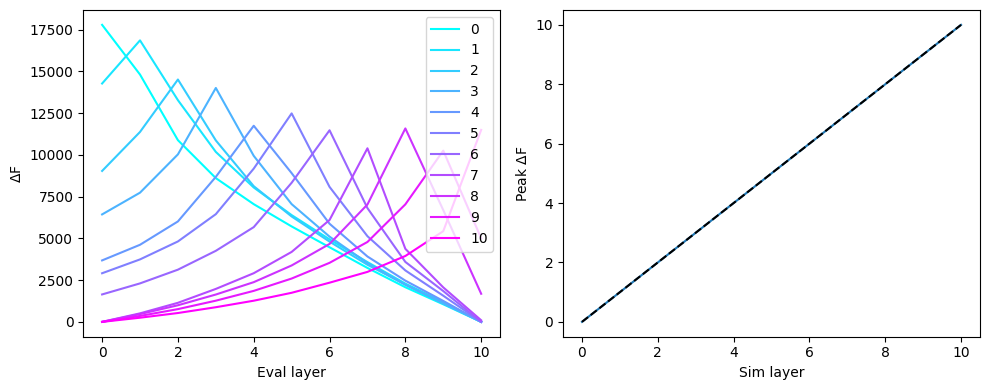

In [13]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF = all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks = []
for l in range(n_layers):
    layerF = all_layerF[l,:]
    pk = np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [14]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)